<font size="+3.8">Scanpy single-cell pre-processing</font>  
<font size="+1.5">ABC Atlas (Yao 2023 Nature)</font>  


Subset and annotate EC subtypes 

In [1]:
from datetime import date
date.today().strftime('%d/%m/%Y')

'06/02/2025'

In [2]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
#warnings.filterwarnings('ignore', category=DeprecationWarning) 

In [3]:
import numpy as np
import pandas as pd
from scipy.stats import median_abs_deviation
import scipy.sparse
import platform
from time import time
from glob import glob
import re
import sys

In [4]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import seaborn as sns

In [5]:
import scanpy as sc
import anndata as ad
sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    frameon=False,
)

In [6]:
import os
os.environ['CONDA_DEFAULT_ENV']

'scanpy'

In [7]:
platform.platform()

'macOS-14.6.1-arm64-arm-64bit'

In [8]:
main_dir = {
    'Windows': r'\\srvisds1.srv.med.uni-muenchen.de\BD-Dichgans\SF\P06_cellseg_benchmark',
    'Darwin': '/Volumes/BD-Dichgans/SF/P06_cellseg_benchmark',
    'Linux': '/cluster2/sfrerich/P06_cellseg_benchmark'
}[platform.system()]
main_dir

'/Volumes/BD-Dichgans/SF/P06_cellseg_benchmark'

# Helper functions

In [9]:
import random
def aggregate_and_filter(
    adata,
    cell_identity,
    donor_key="sample",
    cell_identity_key="cell_type",
    obs_to_keep=[],  # which additional metadata to keep, e.g. gender, age, etc.
    replicates_per_patient=1,
):
    # subset adata to the given cell identity
    adata_cell_pop = adata[adata.obs[cell_identity_key] == cell_identity].copy()
    # check which donors to keep according to the number of cells specified with NUM_OF_CELL_PER_DONOR
    size_by_donor = adata_cell_pop.obs.groupby([donor_key]).size()
    donors_to_drop = [
        donor
        for donor in size_by_donor.index
        if size_by_donor[donor] <= NUM_OF_CELL_PER_DONOR
    ]
    if len(donors_to_drop) > 0:
        print("Dropping the following samples:")
        print(donors_to_drop)
    df = pd.DataFrame(columns=[*adata_cell_pop.var_names, *obs_to_keep])

    adata_cell_pop.obs[donor_key] = adata_cell_pop.obs[donor_key].astype("category")
    for i, donor in enumerate(donors := adata_cell_pop.obs[donor_key].cat.categories):
        print(f"\tProcessing donor {i+1} out of {len(donors)}...", end="\r")
        if donor not in donors_to_drop:
            adata_donor = adata_cell_pop[adata_cell_pop.obs[donor_key] == donor]
            # create replicates for each donor
            indices = list(adata_donor.obs_names)
            random.shuffle(indices)
            indices = np.array_split(np.array(indices), replicates_per_patient)
            for i, rep_idx in enumerate(indices):
                adata_replicate = adata_donor[rep_idx]
                # specify how to aggregate: sum gene expression for each gene for each donor and also keep the condition information
                agg_dict = {gene: "sum" for gene in adata_replicate.var_names}
                for obs in obs_to_keep:
                    agg_dict[obs] = "first"
                # create a df with all genes, donor and condition info
                df_donor = pd.DataFrame(adata_replicate.X.A)
                df_donor.index = adata_replicate.obs_names
                df_donor.columns = adata_replicate.var_names
                df_donor = df_donor.join(adata_replicate.obs[obs_to_keep])
                # aggregate
                df_donor = df_donor.groupby(donor_key).agg(agg_dict)
                df_donor[donor_key] = donor
                df.loc[f"donor_{donor}_{i}"] = df_donor.loc[donor]
    print("\n")
    # create AnnData object from the df
    adata_cell_pop = sc.AnnData(
        df[adata_cell_pop.var_names], obs=df.drop(columns=adata_cell_pop.var_names)
    )
    
    return adata_cell_pop

## Merge and preprocess

Cell level adatas subsetted and exported in previous script

In [10]:
# load
# exported in previous script
setdate = "20250205" # raw
vasc_v2 = sc.read_h5ad(os.path.join(main_dir, "ABCAtlas_Yao2023Nature", "anndata-objects", setdate + "_merged_v2_vascular_subset.h5ad.gz"))
vasc_v3 = sc.read_h5ad(os.path.join(main_dir, "ABCAtlas_Yao2023Nature", "anndata-objects", setdate + "_merged_v3_vascular_subset.h5ad.gz"))

In [11]:
adata = sc.concat([vasc_v2, vasc_v3])
assert adata.shape[0] == vasc_v2.shape[0] + vasc_v3.shape[0]

In [12]:
adata

AnnData object with n_obs × n_vars = 137493 × 32285
    obs: 'key', 'class', 'subclass', 'neurotransmitter', 'library_method', 'cell_type_dea', 'donor_id'

In [13]:
adata.X.max()

11045.0

In [14]:
# log-normalize

In [15]:
adata.layers['counts'] = adata.X.copy()
adata.layers['log1p_norm'] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e6, layer='log1p_norm')
sc.pp.log1p(adata, layer='log1p_norm')
adata.X = adata.layers["log1p_norm"]

In [16]:
# scale genes to unit variance and zero mean, don't clip values at >X standard deviations (max_value)
adata.layers["zscore"] = sc.pp.scale(adata.layers["log1p_norm"], zero_center=True, max_value=None)
# equals scipy.stats.zscore(dense_data, axis=0) # column-wise = gene-wise

In [17]:
adata.layers

Layers with keys: counts, log1p_norm, zscore

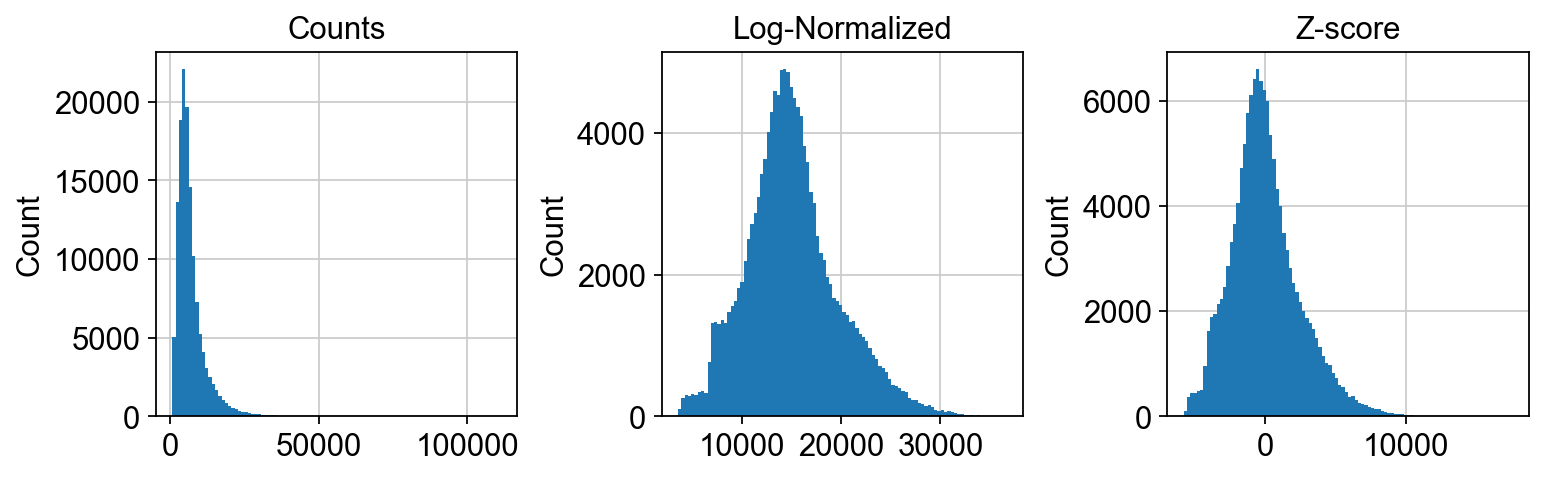

In [18]:
# Show counts per cell (across all cells)
fig, axs = plt.subplots(1, 3, figsize=(11, 3), gridspec_kw={'wspace': 0.4})
titles = ['Counts', 'Log-Normalized', "Z-score"]
for ax, data, bins, title in zip(
        axs,
        [adata.layers["counts"].sum(1), 
         adata.layers["log1p_norm"].sum(1), 
         adata.layers["zscore"].sum(1)],
        [100, 100, 100],
        titles
  ):
        sns.histplot(data, kde=False, bins=bins, ax=ax, zorder=2, alpha=1)
        ax.set_title(title)
        ax.grid(True)
        legend = ax.get_legend()
        if legend is not None:
            legend.remove()
        for patch in ax.patches:
            patch.set_edgecolor('none')
plt.show()

In [19]:
adata.X = adata.layers["zscore"]

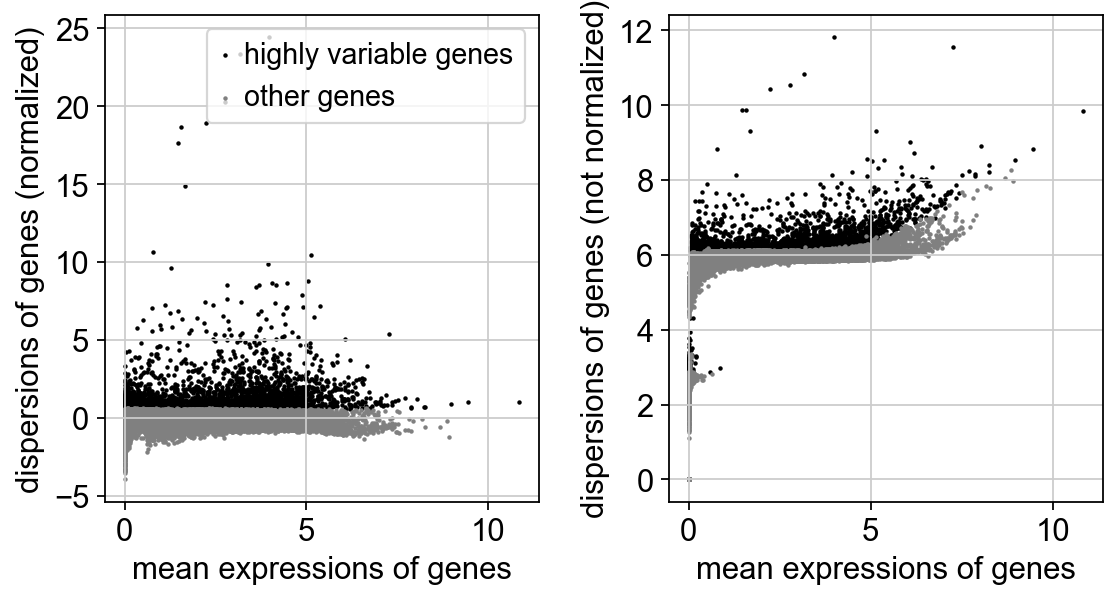

In [20]:
sc.pp.highly_variable_genes(adata, n_top_genes=4000, batch_key="library_method", layer="log1p_norm")
sc.pl.highly_variable_genes(adata)

In [21]:
sc.tl.pca(adata)

In [22]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


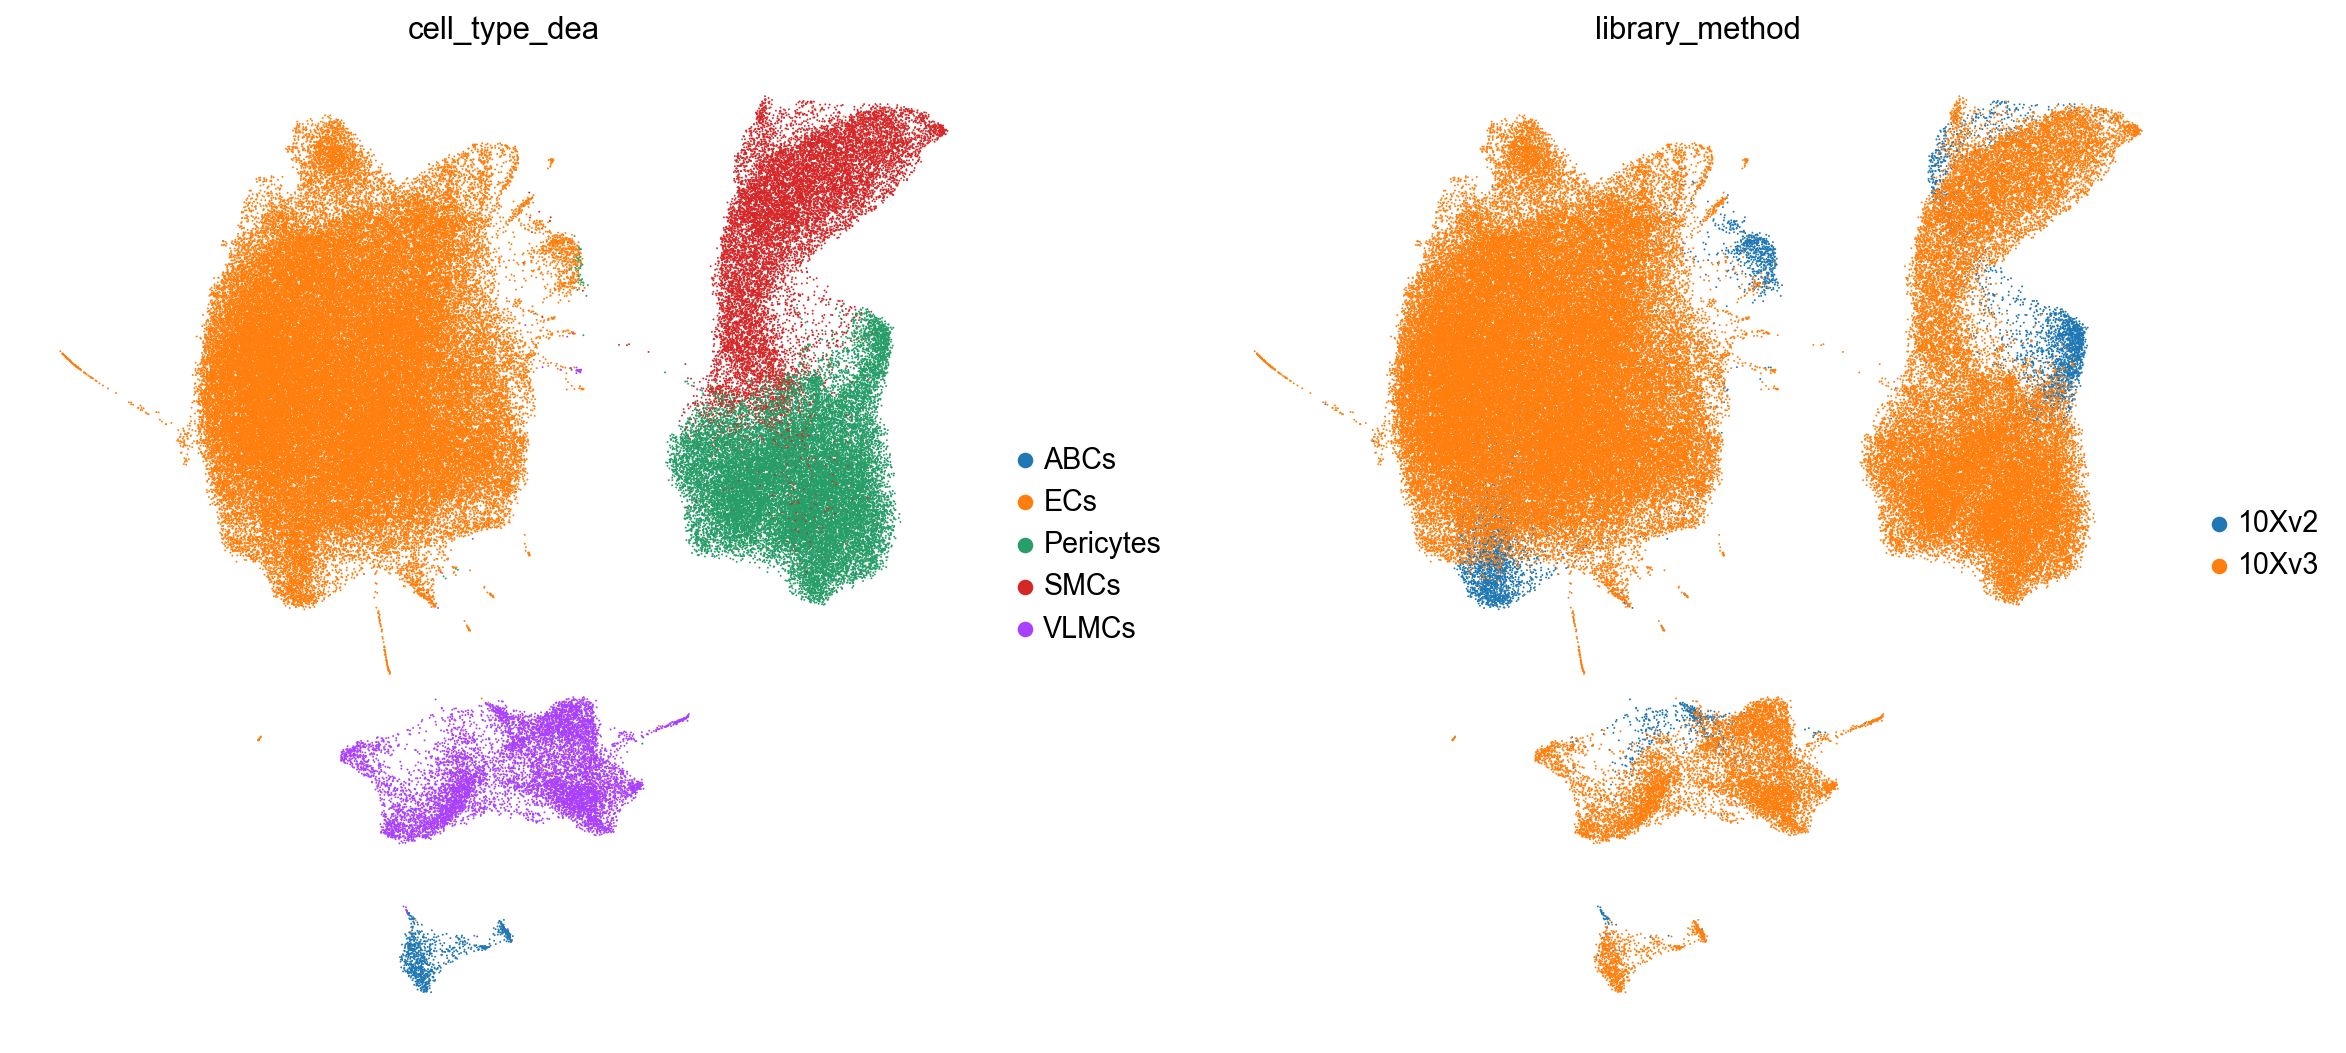

In [23]:
# 4k hvgs - zscored
with rc_context({'figure.figsize': (8,8)}):
    sc.pl.umap(
        adata,
        color=["cell_type_dea", "library_method"],
        size=3,
    )

In [24]:
adata.obsm["X_umap_unintegrated"] = adata.obsm["X_umap"].copy()
adata.obsm["X_pca_unintegrated"] = adata.obsm["X_pca"].copy()

In [25]:
del adata.uns["pca"]
del adata.obsm["X_pca"]
del adata.uns["neighbors"]
del adata.obsp["distances"]
del adata.obsp["connectivities"]
del adata.uns["umap"]
del adata.obsm["X_umap"]

## Integrate

In [26]:
# Set zscore as default adata.X
adata.X = adata.layers["zscore"]

In [27]:
sc.tl.pca(adata)

In [28]:
%%time
sc.external.pp.harmony_integrate(adata, key='library_method')

2025-02-05 14:24:00,597 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-02-05 15:24:45,295 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-02-05 15:24:45,610 - harmonypy - INFO - Iteration 1 of 10
2025-02-05 15:25:31,338 - harmonypy - INFO - Iteration 2 of 10
2025-02-05 15:26:05,409 - harmonypy - INFO - Converged after 2 iterations


CPU times: user 9h 23s, sys: 25min 51s, total: 9h 26min 14s
Wall time: 1h 2min 4s


In [29]:
%%time
sc.pp.neighbors(adata, use_rep='X_pca_harmony', n_pcs=50)
sc.tl.umap(adata)

CPU times: user 1min 28s, sys: 20.6 s, total: 1min 49s
Wall time: 1min 2s


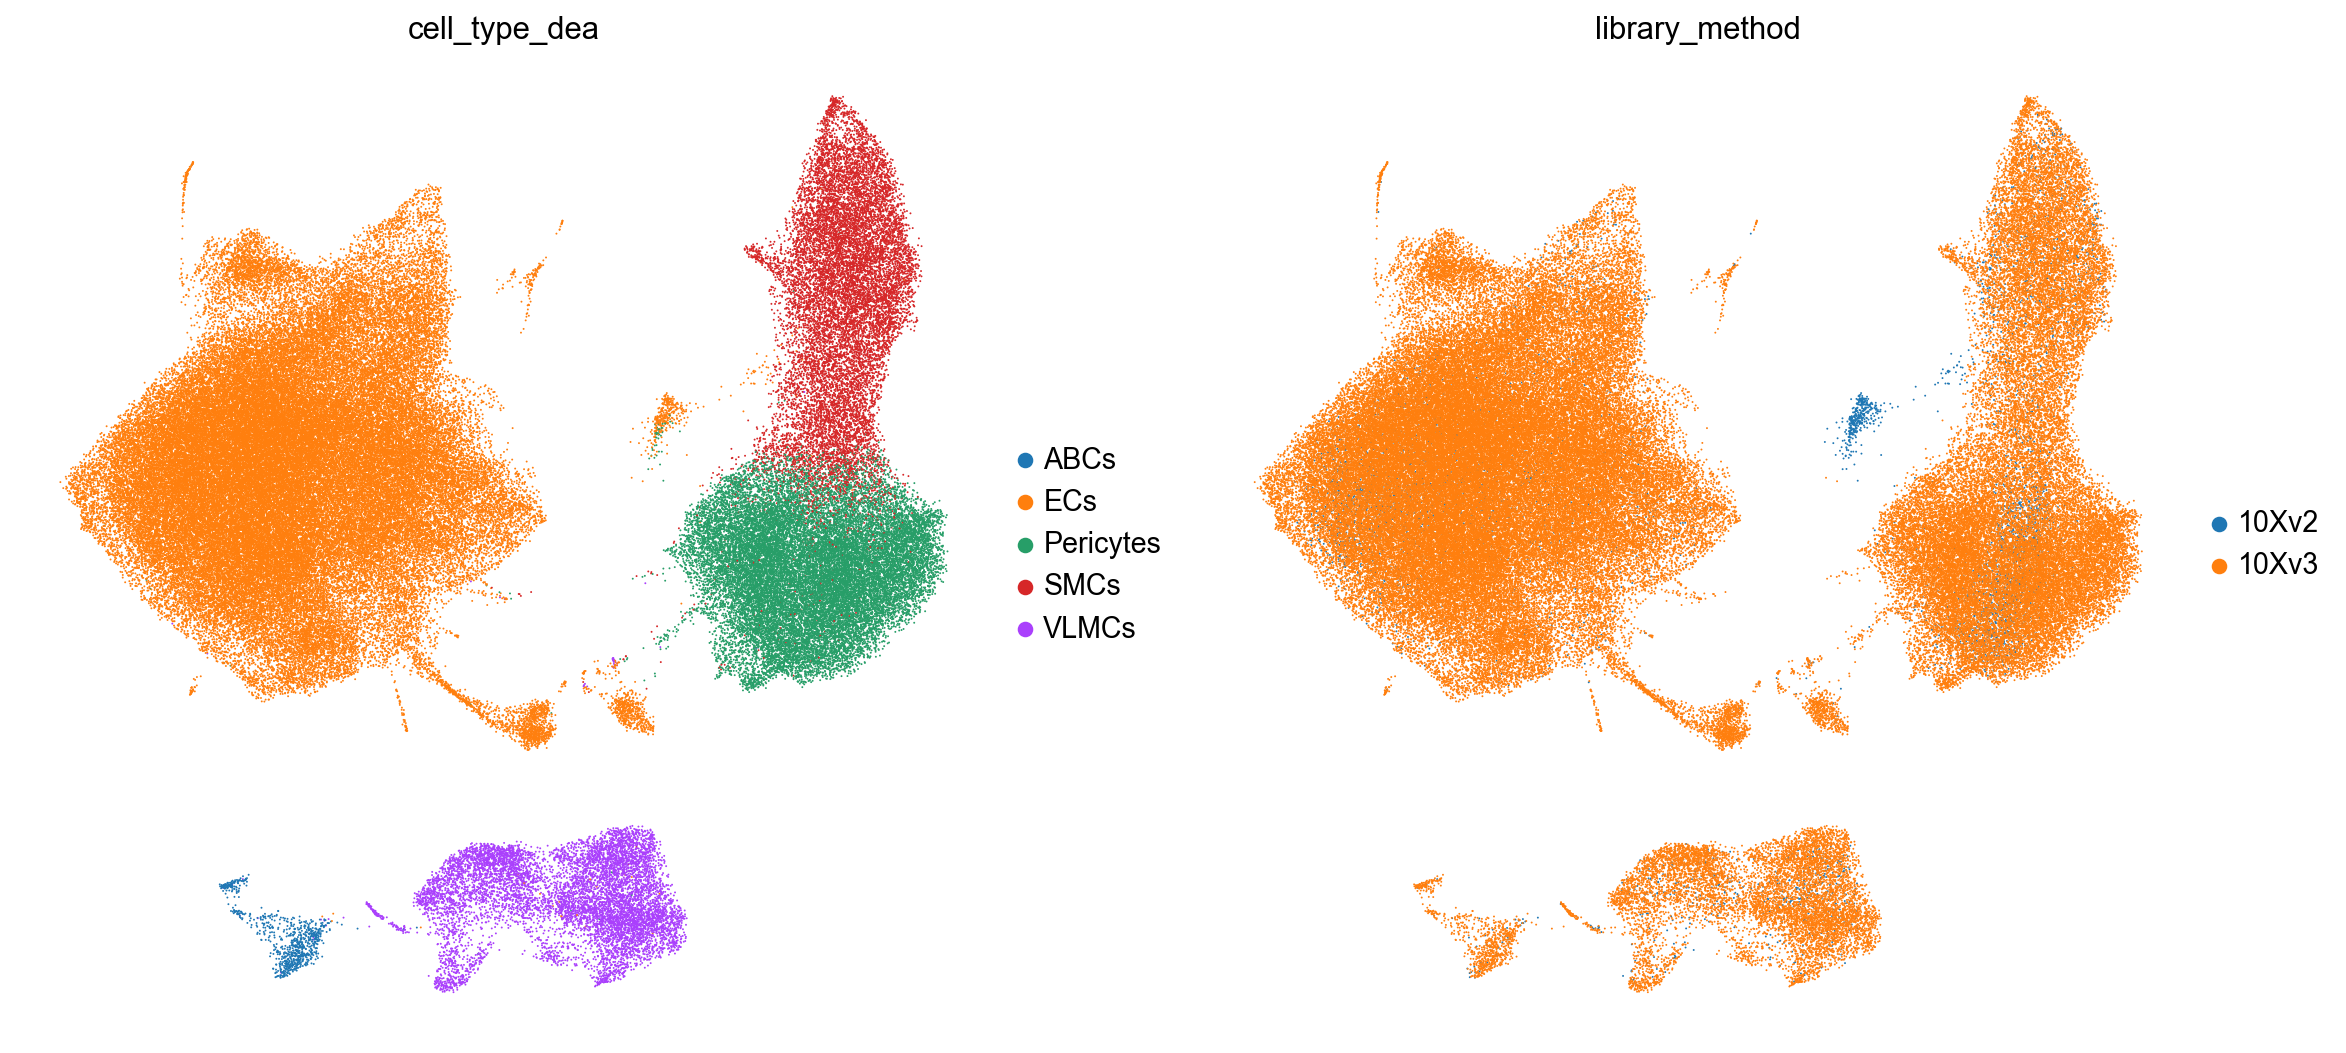

In [30]:
# no hvgs - zscored - integrated
with rc_context({'figure.figsize': (8,8)}):
    sc.pl.umap(
        adata,
        color=["cell_type_dea", "library_method"],
        size=3,
    )

## Cluster

In [31]:
resolutions = [0.05, 0.1, 0.2, 0.25, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
for res in resolutions:
    sc.tl.leiden(adata, key_added=f"leiden_res{res}".replace(".", "_"), resolution=res)

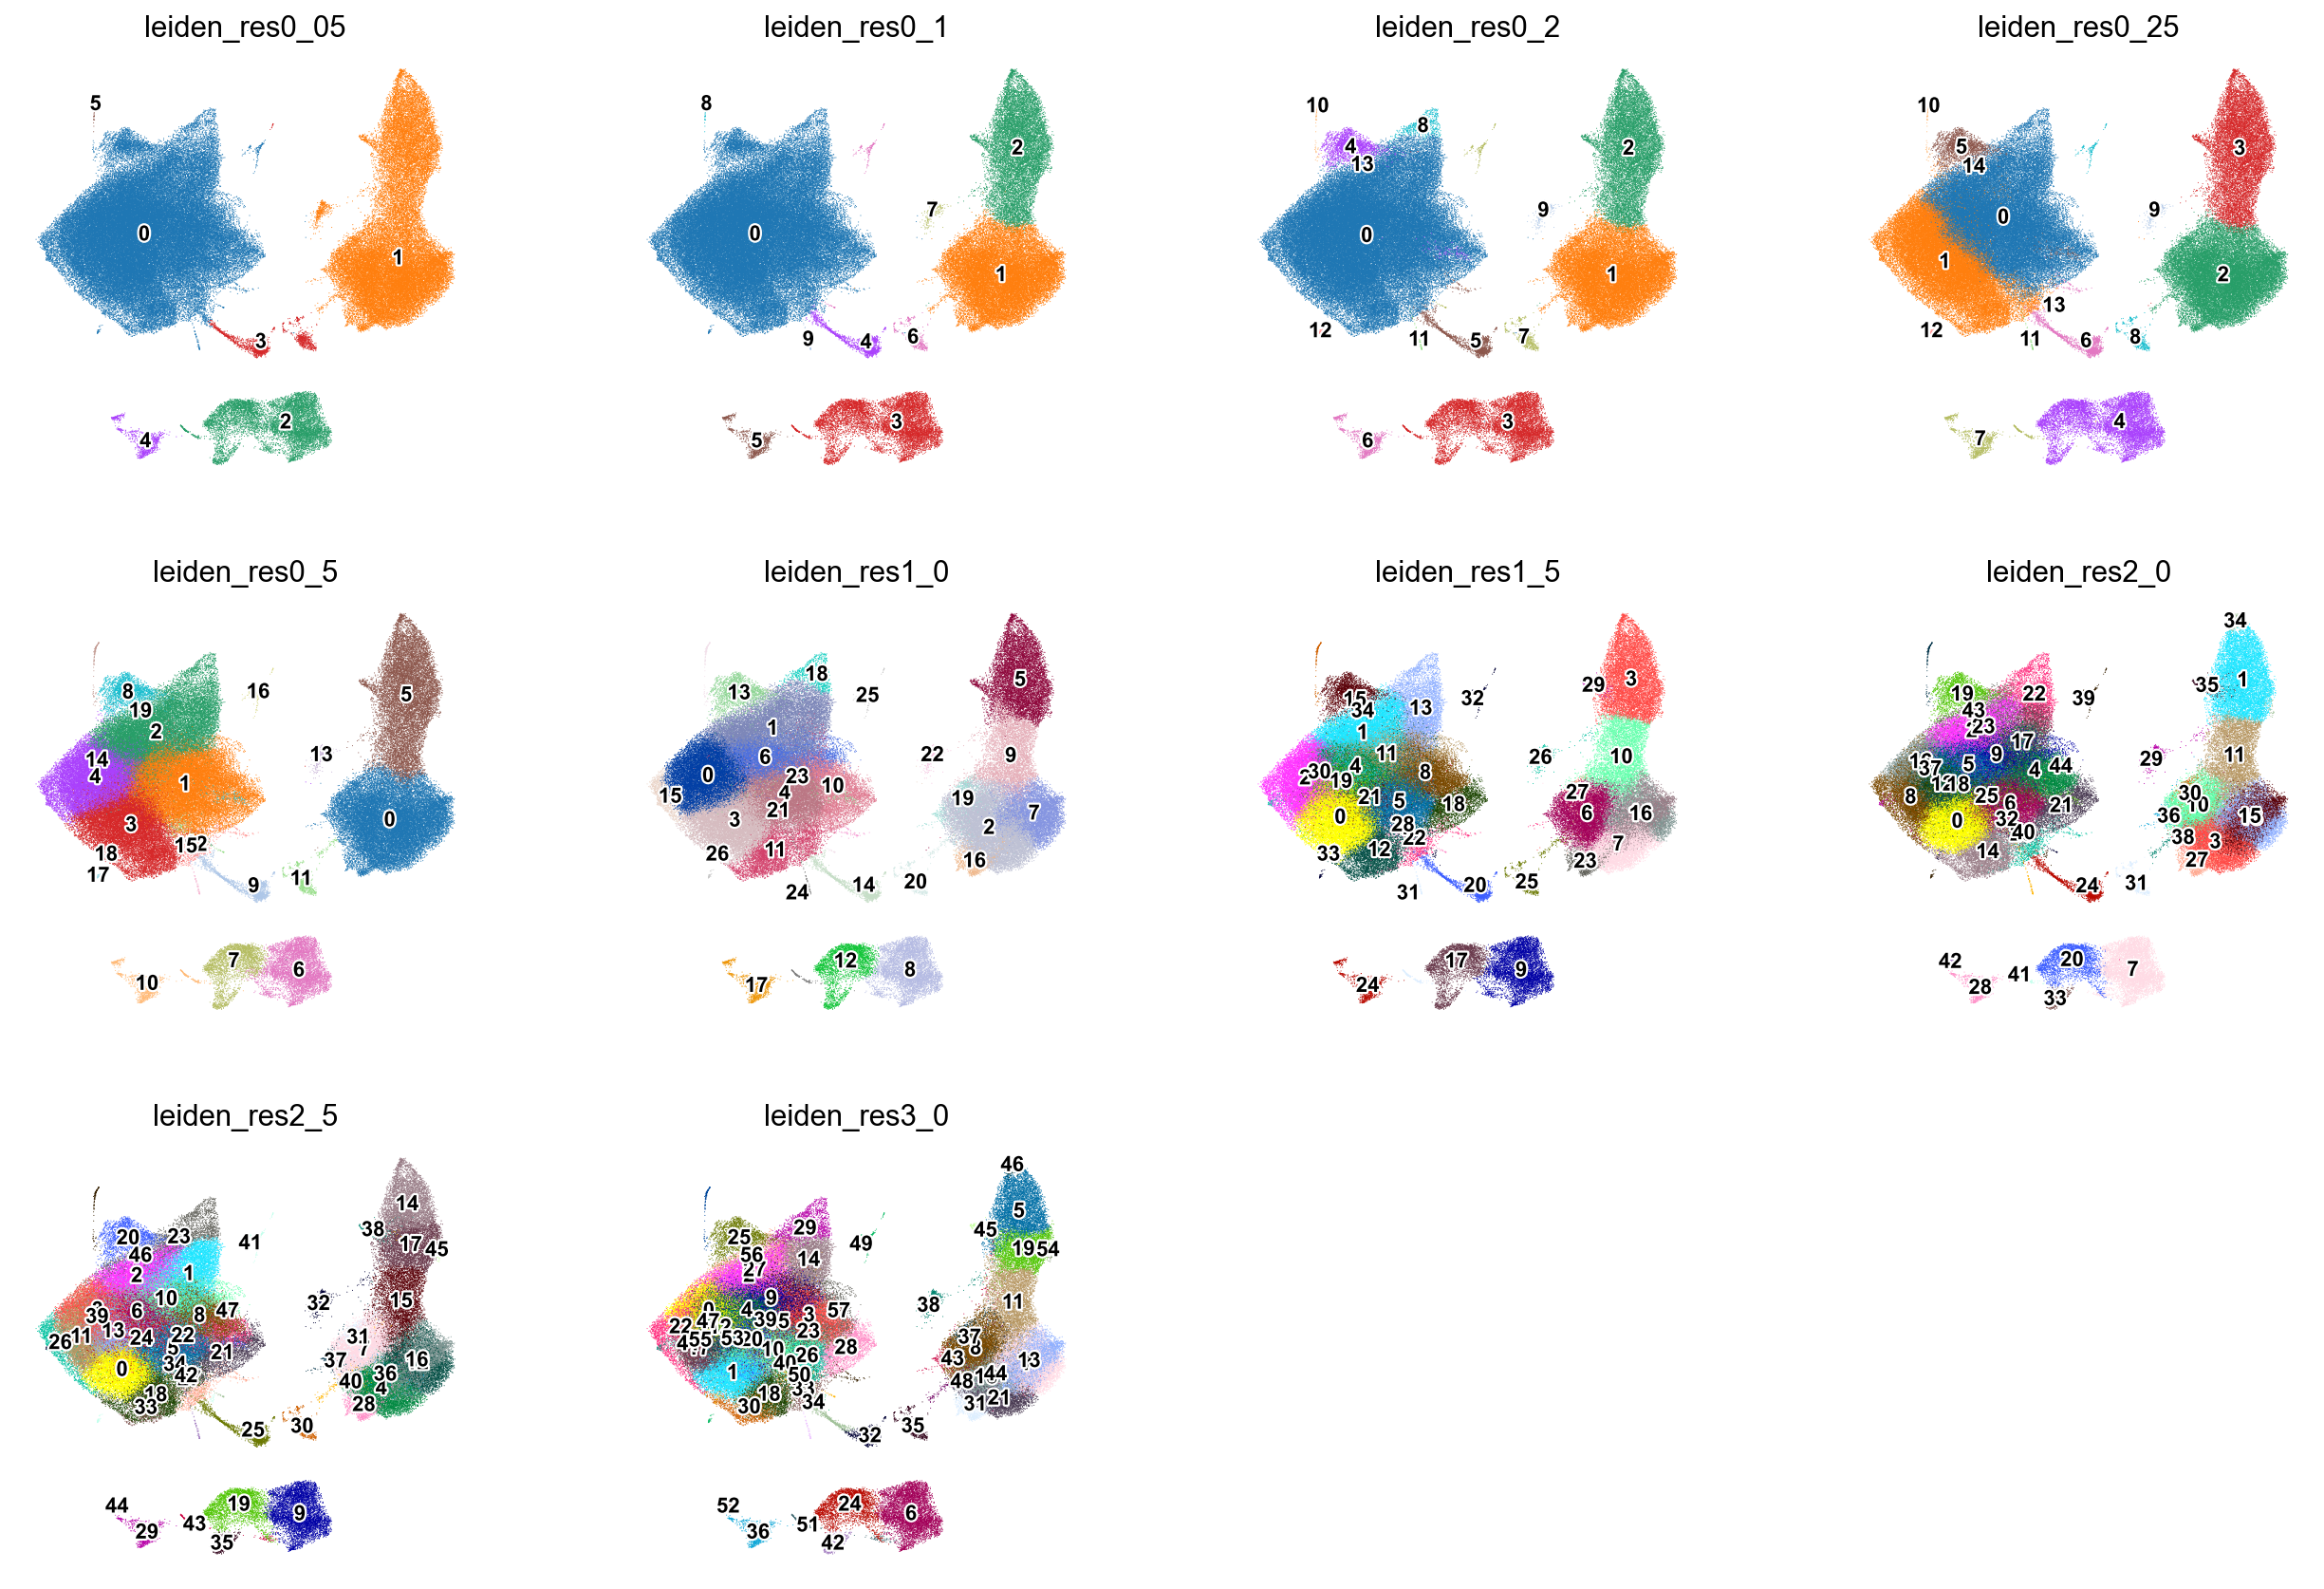

In [32]:
color_keys = [f"leiden_res{res}".replace(".", "_") for res in resolutions]
sc.pl.umap(
        adata,
        color=color_keys,
        legend_loc="on data",
        ncols = 4, legend_fontoutline=2, legend_fontsize=10
)

In [49]:
# select best res for annotation
res = 1.0
res = f"leiden_res{res}".replace(".", "_")

## Save/Load

In [12]:
name='ABCAtlas_vascular_integrated'

In [36]:
# save
adata.write(os.path.join(main_dir, "ABCAtlas_Yao2023Nature", "anndata-objects", date.today().strftime("%Y%m%d")+"_"+name+".h5ad.gz"),
            compression = "gzip")

In [37]:
adata.shape

(137493, 32285)

In [13]:
# load
setdate = "20250205"
x = os.listdir(os.path.join(main_dir, "ABCAtlas_Yao2023Nature", "anndata-objects"))
pattern = re.compile(setdate+r'_'+name+'.*\.h5ad.gz$')
x = [val for val in x if pattern.match(val)]
x

['20250205_ABCAtlas_vascular_integrated.h5ad.gz']

In [14]:
adata = sc.read_h5ad(os.path.join(main_dir, "ABCAtlas_Yao2023Nature","anndata-objects",x[0]))

In [ ]:
adata

## Marker genes

In [17]:
def sort_and_score(adatatemp, marker_genes):
    
    marker_genes_in_data = {}
    for ct, markers in marker_genes.items():
        markers_found = []
        for marker in markers:
            if marker in adatatemp.var.index:
                markers_found.append(marker)
        if markers_found:
            marker_genes_in_data[ct] = markers_found

    for key in marker_genes_in_data.keys():
        sc.tl.score_genes(adatatemp, marker_genes_in_data[key], score_name=key)
        
    return adatatemp, marker_genes_in_data

In [18]:
cell_cyle_genes = {
"G1":["Ccne1","Pttg1"],
"G1_S":["Slbp","Cdca7","Ung","Cdc6","Pcna","Mcm5","Orc1","Dtl"],
"S":["Rrm2","E2f8","Atad2"],
"G2":["Ccnf","Cdca8","Hjurp","Cdk1","Top2a","Kif23"],
"G2_M":["Kpna2","Bub1b","Tacc3"],
"M":["Plk1","Mapk13","Aurka","Tpx2"],
"Proliferation":["Mki67"]
}

In [19]:
# cell supertypes from gene panel
# also contain cell(sub)-type specific genes 
cell_supertypes_merfish_panel_500_mouse_brain = {
'Vascular':['Cldn5', 'Cdh5', 'Pecam1', 'Kdr', 'Flt1', 'Tie1', 'Tek', 'Nos3', 'Ocln', 'Pdgfb', 'Mgp', 'Cytl1', 'Fbln5', 'Clu', 'Eln', 'Bmx', 'Efnb2', 'Vegfc', 'Sema3g', 'Gkn3', 'Fbln2', 'Hey1', 'Egfl8', 'Jag1', 'Igf2', 'Notch3', 'Tgfb2', 'Rad54b', 'Slc26a10', 'Slc7a5', 'Mfsd2a', 'Tfrc', 'Slc16a1', 'Meox1', 'Col4a3', 'Angpt2', 'Rgcc', 'Cxcl12', 'Ecscr', 'Apln', 'Car4', 'Slc38a5', 'Gatm', 'Itm2a', 'Flt4', 'Vwf', 'Nr2f2', 'Flrt2', 'Ier3', 'Vcam1', 'Ly6c1', 'Ly6a', 'Ctsc', 'Ackr1', 'Lcn2', 'Icam1', 'Tmem252', 'Apoe', 'App', 'Mfge8', 'Prdx1', 'Prdx2', 'Prdx6', 'Sod1', 'Sod2', 'Ifit1', 'Depp1', 'S100a6', 'Cd9', 'Hif1a', 'Notch1', 'Fscn1', 'Plvap', 'Ccn2', 'Fgfbp1', 'Bmp6', 'Bgn', 'Ly6e', 'Acer2', 'B2m', 'Cxcr4', 'Pgf', 'Adamts1', 'Plaur', 'Cx3cl1', 'Vtn', 'Kcnj8', 'Pdgfrb', 'Cspg4', 'Rgs5', 'Cd248', 'Abcc9', 'Anpep', 'Atp13a5', 'Higd1b', 'Cd93', 'Col4a1', 'Col4a2', 'Col4a4', 'Lama4', 'Slc20a2', 'Slc1a3', 'Slc6a13', 'Pdgfa', 'Acta2', 'Pdlim3', 'Tagln', 'Myh11', 'Sncg', 'Cnn1', 'Pln', 'Arl4d', 'Atf3', 'H2afj', 'Nanos1', 'Abca1', 'AI593442', 'Col6a2', 'Dcn', 'Col1a1', 'Lama1', 'Fn1', 'Slc7a11', 'Il33', 'Gjb2', 'Aldh1a2', 'Thbd', 'Slc47a1', 'Abcg2', 'Dpp4', 'Slc7a14', 'Cldn11', 'Lsr', 'Slc4a10', 'Pdgfra', 'Slc22a2', 'Prox1', 'Fxyd5', 'Foxp1', 'Crabp2', 'Ngfr', 'Cd68', 'Ereg', 'Lgals3', 'Spp1', 'Vim', 'Klf4', 'Klf5', 'Mmp2', 'Mmp9', 'Msx2', 'Myocd', 'Runx2', 'Sox9', 'Srf', 'Tgfb1', 'Cdh2', 'Col1a2', 'Tgfb3', 'Tgfbr1', 'Tgfbr2', 'Pdgfc', 'Pdgfd', 'Notch2', 'Notch4', 'Dll1', 'Dll3', 'Dll4', 'Jag2', 'Angpt1', 'Ang2', 'Angptl1', 'Ang4', 'Vegfa', 'Vegfb', 'Vegfd', 'Cd74', 'Osr1', 'Col23a1', 'Arl15', 'Hsp90aa1', 'Plpp3'],
'Immune':['Mrc1', 'Cx3cr1', 'Cd163', 'Pf4', 'Cd74', 'Lyz2', 'Ms4a7', 'Clec12a', 'Lgals3', 'Ctss', 'Tmem119', 'Aif1', 'Cd68', 'Trem2', 'Itgam', 'Itgax', 'P2ry12', 'Csf1r', 'Laptm5', 'C1qa', 'Axl', 'Spp1', 'Apoe', 'Lpl', 'H2-Aa', 'Ccl4', 'Ccl3', 'B2m', 'Cd9', 'C1qc', 'Dpp10', 'Meg3', 'Cd3e', 'Ptprc', 'Cd3g', 'Nkg7', 'Gzma', 'Cd79a', 'Gata3', 'Fn1'],
'Oligodendroglia':['Plp1', 'Cnp', 'Cldn11', 'Mbp', 'Mag', 'Mog', 'Enpp2', 'Trf', 'Apod', 'Plxnb3', 'Olig2', 'Enpp6', 'Olig1', 'Opalin', 'Bmp4', 'Klk6', 'Vcan', 'Prox1', 'C4b', 'Il33', 'Il18', 'Tcf7l2', 'Cemip2', 'Pdgfa', 'Ctps', 'S100b', 'Pdgfra', 'Vim', 'Eno2', 'Serpina3n', 'Plvap', 'Cdkn1a', 'Klf4', 'Stat1', 'Ifit1', 'Ptprz1', 'Cspg4', 'Cspg5', 'Rgcc', 'Cd9', 'Sox10', 'Nkx2-2'],
'Astrocytes':['Aldoc', 'Apoe', 'Clu', 'Plpp3', 'Slc1a3', 'Ptprz1', 'Prdx6', 'Mlc1', 'Kcnj10', 'Aqp4', 'Lama2', 'Snta1', 'Gfap', 'Mfge8', 'C4b', 'Serpina3n', 'Vim', 'Il18', 'Hif3a'],
'Neurons':['Meg3', 'Arpp21', 'Slc17a7', 'Ptprd', 'Gad2', 'Gad1', 'Galntl6', 'Rbfox3', 'Map2', 'Slc32a1', 'Otof', 'Drd1', 'Adora2a', 'Cux2', 'Scube1', 'Fezf2', 'Lamp5', 'Tshz2', 'Hs3st4', 'Eno2', 'Gphn', 'Ncam1', 'Nefl', 'Prkcg', 'Reln', 'Gm12371', 'Krt12', 'A830036E02Rik', 'Hs3st2', 'Pde1a', 'Rell1', 'Tbr1', 'Rorb', 'Rspo1', 'Sulf2', 'Osr1', 'Pvalb', 'Sst', 'Vip', 'Sncg']
}

In [20]:
# cell types from gene panel
# also contain sub-type specific genes 
cell_types_merfish_panel_500_mouse_brain = {
'ECs':['Cldn5', 'Cdh5', 'Pecam1', 'Kdr', 'Flt1', 'Tie1', 'Tek', 'Nos3', 'Ocln', 'Pdgfb', 'Mgp', 'Cytl1', 'Fbln5', 'Clu', 'Eln', 'Bmx', 'Efnb2', 'Vegfc', 'Sema3g', 'Gkn3', 'Fbln2', 'Hey1', 'Egfl8', 'Jag1', 'Igf2', 'Notch3', 'Tgfb2', 'Rad54b', 'Slc26a10', 'Slc7a5', 'Mfsd2a', 'Tfrc', 'Slc16a1', 'Meox1', 'Col4a3', 'Angpt2', 'Rgcc', 'Cxcl12', 'Ecscr', 'Apln', 'Car4', 'Slc38a5', 'Gatm', 'Itm2a', 'Flt4', 'Vwf', 'Nr2f2', 'Flrt2', 'Ier3', 'Vcam1', 'Ly6c1', 'Ly6a', 'Ctsc', 'Ackr1', 'Lcn2', 'Icam1', 'Tmem252', 'Apoe', 'App', 'Mfge8', 'Prdx1', 'Prdx2', 'Prdx6', 'Sod1', 'Sod2', 'Ifit1', 'Depp1', 'S100a6', 'Cd9', 'Hif1a', 'Notch1', 'Fscn1', 'Plvap', 'Ccn2', 'Fgfbp1', 'Bmp6', 'Bgn', 'Ly6e', 'Acer2', 'B2m', 'Cxcr4', 'Pgf', 'Adamts1', 'Plaur', 'Cx3cl1', 'Arl15', 'Hsp90aa1', 'Plpp3'],
'Pericytes':['Vtn', 'Kcnj8', 'Rgs5', 'Cd248', 'Atp13a5', 'Anpep', 'Higd1b', 'Flt1', 'Ecscr', 'Cd93', 'Apln', 'Col4a1', 'Col4a2', 'Col4a3', 'Col4a4', 'Lama4', 'Adamts1', 'Slc20a2', 'Slc1a3', 'Slc6a13', 'Pdgfrb', 'Pdgfa', 'Pdgfb'],
'SMCs':['Acta2', 'Pdlim3', 'Tagln', 'Myh11', 'Sncg', 'Cnn1', 'Pln', 'Adamts1', 'Arl4d', 'Atf3', 'Cd93', 'H2afj', 'Nanos1', 'Abca1', 'AI593442', 'Car4', 'Col6a2'],
'Pericytes_SMCS':['Pdgfrb', 'Cspg4', 'Abcc9', 'Anpep'],
'Fibroblasts':['Dcn', 'Col1a1', 'Lama1', 'Fn1', 'Slc7a11', 'Il33', 'Slc6a13', 'Gjb2', 'Aldh1a2', 'Thbd', 'Slc47a1', 'Mgp', 'Abcg2', 'Dpp4', 'Slc7a14', 'Cldn11', 'Lsr', 'Slc4a10', 'Pdgfra', 'Slc22a2', 'Prox1', 'Anpep', 'Fxyd5', 'Foxp1', 'Crabp2', 'S100a6', 'Ngfr', 'Pdgfrb'],
'Ependymal cells':['Ccdc153', 'Tmem212', 'Pifo', 'Foxj1', 'Dpp10', 'Col23a1', 'Rax', 'Folr1', 'Clic6'],
'Hypendymal cells':['Sspo', 'Spp2'],
'Glycocalyx-related':['Dcn', 'Vcan', 'Bgn', 'B4galt5', 'Sulf2'],
'Microglia':['Cx3cr1', 'Ctss', 'Tmem119', 'P2ry12', 'Itgam', 'Csf1r', 'Laptm5', 'Lyz2', 'Itgax', 'Axl', 'Spp1', 'Trem2', 'Apoe', 'Lgals3', 'Lpl', 'Cd74', 'H2-Aa', 'Ccl4', 'Ccl3', 'B2m', 'Cd9', 'C1qa', 'C1qc', 'Dpp10', 'Meg3'],
'Macrophages':['Cd163', 'Pf4', 'Cd74', 'Lyz2', 'Ms4a7', 'Mrc1', 'Clec12a', 'Lgals3', 'Cd68', 'Apoe', 'Spp1', 'Lpl'],
'Microglia_Macrophages':['Trem2', 'Cx3cr1', 'Aif1', 'Itgam', 'Itgax', 'C1qc', 'Ctss', 'C1qa', 'Csf1r', 'Laptm5', 'B2m', 'P2ry12', 'Mrc1'],
'Pan-myeloid':['Ctss', 'C1qa'],
'Lymphoid cells':['Cd3e', 'Cd3g', 'Nkg7', 'Gzma', 'Cd79a', 'Gata3'],
'Monocytes_Neutrophils': ['Itgam'],
'Infiltrating leukocytes': ['Ptprc'],
'Granulocytes': ['Lyz2', 'Fn1'],
'Myeloid dendritic cells': ['Itgax'],
'Oligodendrocytes':['Plp1', 'Cnp', 'Cldn11', 'Mbp', 'Mag', 'Mog', 'Enpp2', 'Trf', 'Apod', 'Plxnb3', 'Olig2', 'Enpp6', 'Olig1', 'Opalin', 'Bmp4', 'Klk6', 'Vcan', 'Prox1', 'C4b', 'Il33', 'Il18', 'Tcf7l2', 'Cemip2', 'Pdgfa', 'Ctps', 'S100b', 'Pdgfra', 'Vim', 'Eno2', 'Serpina3n', 'Plvap', 'Cdkn1a', 'Klf4', 'Stat1', 'Ifit1'],
'OPCs':['Ptprz1', 'Pdgfra', 'Cspg4', 'Olig1', 'Cspg5', 'Rgcc', 'Olig2', 'Vcan', 'Cd9', 'Sox10', 'Apod', 'Nkx2-2', 'Bmp4'],
'Astrocytes':['Aldoc', 'Apoe', 'Clu', 'Plpp3', 'Slc1a3', 'Ptprz1', 'Prdx6', 'Mlc1', 'Kcnj10', 'Aqp4', 'Lama2', 'Snta1', 'Gfap', 'Mfge8', 'C4b', 'Serpina3n', 'Vim', 'Il18', 'Hif3a'],
'Neurons':['Meg3', 'Arpp21', 'Slc17a7', 'Ptprd', 'Gad2', 'Gad1', 'Galntl6', 'Rbfox3', 'Map2', 'Slc32a1', 'Otof', 'Drd1', 'Adora2a', 'Cux2', 'Scube1', 'Fezf2', 'Lamp5', 'Tshz2', 'Hs3st4', 'Eno2', 'Gphn', 'Ncam1', 'Nefl', 'Prkcg', 'Reln', 'Gm12371', 'Krt12', 'A830036E02Rik', 'Hs3st2', 'Pde1a', 'Rell1', 'Tbr1', 'Rorb', 'Rspo1', 'Sulf2', 'Osr1', 'Pvalb', 'Sst', 'Vip', 'Sncg']   
}

In [21]:
# EC cell subtypes from gene panel
vascular_EC_cell_subtypes_merfish_panel_500_mouse_brain = {
'pan-EC':['Cldn5', 'Cdh5', 'Pecam1', 'Kdr', 'Flt1', 'Tie1', 'Tek', 'Nos3', 'Ocln', 'Pdgfb'],
'large artery ECs':['Mgp', 'Cytl1', 'Fbln5', 'Clu', 'Eln'],
'aECs':['Bmx', 'Efnb2', 'Vegfc', 'Sema3g', 'Gkn3', 'Fbln2', 'Hey1', 'Egfl8', 'Jag1', 'Igf2', 'Notch3', 'Mgp', 'Clu'],
'capillary-arterial ECs':['Tgfb2', 'Rad54b', 'Slc26a10'],
'capECs':['Slc7a5', 'Mfsd2a', 'Tfrc', 'Slc16a1', 'Meox1', 'Col4a3', 'Angpt2', 'Rgcc', 'Cxcl12', 'Ecscr', 'Apln', 'Car4'],
'capillary-venous ECs':['Slc38a5', 'Tfrc', 'Slc16a1', 'Car4', 'Gatm', 'Itm2a'],
'post-capillary venules':['Flt4', 'Vwf', 'Nr2f2'],
'vECs':['Nr2f2', 'Slc38a5', 'Flrt2', 'Ier3', 'Vcam1', 'Ly6c1', 'Cldn5', 'Ly6a', 'Ctsc'],
'large vein ECs':['Ackr1', 'Lcn2', 'Vcam1', 'Slc38a5', 'Icam1', 'Tmem252'],
'arterial-venous_large-vessel ECs':['Vcam1', 'Vwf'],
'AD pathology in BEC aging':['Apoe', 'App', 'Mfge8'],
'oxidative stress BEC':['Prdx1', 'Prdx2', 'Prdx6', 'Sod1', 'Sod2'],
'interferon-activated ECs':['Ifit1', 'Slc7a5'],
'shear stress arterial ECs':['Depp1', 'S100a6', 'Cd9'],
'inflammatory vasculature (ECs)':['Vcam1', 'Icam1', 'Lcn2', 'Hif1a', 'Vwf'],
'pro-angiogenic arteriolar ECs':['Jag1', 'Notch1', 'Hey1', 'Vegfc'],
'upregulated in pericyte-deficient mice (ECs)':['Icam1', 'Angpt2'],
'exp lost in pericyte-deficient mice (ECs)':['Mfsd2a'],
'exp lost in microvessel but not larger vessels (veins) of pericyte-deficient mice (ECs)':['Tfrc', 'Slc16a1'],
'angiogenic ECs':['Fscn1', 'Angpt2', 'Meox1'],
'upregulated at BBB leakage site (ECs)':['Plvap', 'Icam1', 'Ccn2'],
'transformed ECs in pericyte-deficient mice':['Fgfbp1', 'Ccn2', 'Bmp6', 'Bgn'],
'upregulated in aged ECs':['Ly6e', 'Acer2', 'Vwf', 'Ly6a', 'Sod1', 'Apoe'],
'Endo-3 (enriched in old mice)':['Ly6a', 'Apoe', 'B2m', 'Bgn'],
'tip ECs':['Cxcr4', 'Pgf', 'Adamts1', 'Plaur', 'Angpt2', 'Meox1'],
'might reflect endothelial cell-microglia communication in inflammatory processes':['Cx3cl1'],
'choroid plexus ECs':['Arl15', 'Hsp90aa1', 'Plvap', 'Plpp3'] 
}

In [22]:
# PC/SMC/Fibroblast/Ependymal cell subtypes from gene panel
vascular_nonEC_cell_subtypes_merfish_panel_500_mouse_brain = {
'Pan-Pericyte':['Vtn', 'Kcnj8', 'Pdgfrb', 'Cspg4', 'Rgs5', 'Cd248', 'Abcc9', 'Anpep', 'Atp13a5'],
'Pericytes3':['Kcnj8', 'Anpep', 'Vtn'],
'Pericytes2':['Ecscr', 'Cd93', 'Apln'],
'Pericytes1':['Higd1b', 'Rgs5', 'Flt1'],
'M_pericytes':['Col4a1', 'Col4a2', 'Col4a3', 'Col4a4', 'Lama4', 'Adamts1'],
'T_pericytes':['Slc20a2', 'Slc1a3', 'Slc6a13'],
'Pericyte_proliferation':['Pdgfrb', 'Pdgfa', 'Pdgfb'],
'SMCs':['Acta2', 'Tagln', 'Pdlim3', 'Sncg'],
'arterial_arteriolar SMCs':['Acta2', 'Tagln', 'Myh11', 'Pln'],
'arterial SMCs':['Cnn1', 'Adamts1', 'Arl4d', 'Atf3'],
'arteriolar SMCs':['Cd93', 'H2afj', 'Nanos1'],
'venous SMCs':['Abca1', 'AI593442', 'Car4', 'Col6a2'],
'Pan-Fibroblast':['Dcn', 'Anpep', 'Pdgfra', 'Pdgfrb'],
'Perivascular Fibroblasts':['Col1a1', 'Lama1', 'Fn1'],
'Perivascular fibroblasts_pia (BFB1_2)':['Slc7a11', 'Lama1'],
'VLMC1':['Dcn', 'Il33', 'Col1a1'],
'VLMC2':['Slc6a13', 'Gjb2', 'Aldh1a2'],
'Arachnoid barrier cells (ABCs)':['Thbd', 'Slc47a1', 'Mgp', 'Abcg2'],
'Arachnoid barrier cells (ABCs) (BFB4)':['Dpp4', 'Slc7a14'],
'Arachnoid barrier cells_dural border cells (BFB4_5)':['Cldn11', 'Lsr'],
'Dural border cells (BFB5)':['Slc4a10', 'Slc47a1'],
'Pia_arachnoid cells below arachnoid barrier cells (BFB2_3)':['Slc22a2'],
'Arachnoid cells below the arachnoid barrier cells (BFB3)':['Prox1'],
'Dural fibroblasts':['Fxyd5', 'Foxp1'],
'Arachnoid fibroblasts':['Crabp2', 'Aldh1a2', 'Slc6a13'],
'Pial fibroblasts':['S100a6', 'Ngfr'],
'SMC_diff': ['Klf4', 'Klf5', 'Mmp2', 'Myocd', 'Srf'],
'SMC_diff (C)': ['Acta2', 'Cnn1', 'Myh11', 'Tagln', 'Msx2', 'Runx2', 'Sox9'],
'SMC_diff (Fib)': ['Bgn', 'Dcn', 'Spp1'],
'SMC_diff (F)': ['Cd68', 'Lgals3'],
'SMC_diff (S)': ['Ereg', 'Vim', 'Mmp9', 'Fn1'],
'SMC_diff (Myo)': ['Pdgfrb'],
'EndMT': ['Tgfb1', 'Kdr'],
'EndMT (EC)': ['Tek', 'Tie1', 'Cdh5', 'Vwf', 'Pecam1'],
'EndMT (M)': ['Tagln', 'Cnn1', 'Acta2', 'Vim', 'Fn1', 'Col1a1', 'Col1a2', 'Mmp2', 'Mmp9', 'Cdh2'],
'Pan-Ependymal':['Pifo', 'Foxj1', 'Dpp10'],
'Ependymocytes cells':['Ccdc153', 'Tmem212'],
'Tanycytes':['Col23a1', 'Rax'],
'Choroidal epithelial cells':['Folr1', 'Clic6'],
'Hypendymal cells':['Sspo', 'Spp2'],
'Glycocalyx-related':['Dcn', 'Vcan', 'Bgn', 'B4galt5', 'Sulf2']
}

In [23]:
adatatemp = adata

Plot and export

In [24]:
samplename = "ABCAtlas_vasc_subset"

In [25]:
os.path.join(main_dir, "ABCAtlas_Yao2023Nature", "zonation_annotation", "plots_marker_genes")

'/Volumes/BD-Dichgans/SF/P06_cellseg_benchmark/ABCAtlas_Yao2023Nature/zonation_annotation/plots_marker_genes'

In [26]:
output_dir_plots = os.path.join(main_dir, "ABCAtlas_Yao2023Nature", "zonation_annotation", "plots_marker_genes")
os.makedirs(output_dir_plots, exist_ok=True)

### Cell cycle

Score groups:

In [54]:
adatatemp, marker_genes_in_data = sort_and_score(adatatemp, cell_cyle_genes)

In [55]:
name = "cell_cycle"

In [57]:
with rc_context({'figure.figsize': (6,6)}):
    sc.pl.umap(
    adatatemp,
    color=marker_genes_in_data.keys(), 
    frameon= False, ncols=3,
    cmap='RdYlBu_r', vmin=0, vmax=0.7, 
    #size=pt_size, 
    sort_order=True,
    show=False
    )
plt.savefig(f'{output_dir_plots}/{date.today().strftime("%Y%m%d")}_{samplename}_{name}_UMAP_scores.png', bbox_inches="tight")
plt.close()

Individual marker genes:

In [58]:
os.makedirs(f'{output_dir_plots}/{date.today().strftime("%Y%m%d")}_{samplename}_{name}_UMAP_genes')
for ct in marker_genes_in_data:
    #with rc_context({'figure.figsize': (10, 10)}):
        print(f"{ct.upper()}")  # print cell subtype name
        sc.pl.umap(
            adatatemp,
            color=marker_genes_in_data[ct],
            frameon=False,
            ncols=3,
            vmin=0,
            #vmax=0.9,
            vmax="p99",  # set vmax to the 99th percentile of the gene count instead of the maximum, to prevent outliers from making expression in other cells invisible. Note that this can cause problems for extremely lowly expressed genes.
            sort_order=True,  # do not plot highest expression on top, to not get a biased view of the mean expression among cells
            cmap="Reds",  # or choose another color map e.g. from here: https://matplotlib.org/stable/tutorials/colors/colormaps.html
            show=False
        )
        plt.savefig(f'{output_dir_plots}/{date.today().strftime("%Y%m%d")}_{samplename}_{name}_UMAP_genes/{ct}.png', bbox_inches="tight")
        plt.close()
        #print("\n\n\n")  # print white space for legibility

G1
G1_S
S
G2
G2_M
M
PROLIFERATION


### Cell types

Score groups:

#### Cell Supertypes
From MERFISH gene panel google sheet

In [27]:
# load above
adatatemp, marker_genes_in_data = sort_and_score(adatatemp, cell_supertypes_merfish_panel_500_mouse_brain)

In [28]:
name = "cell_supertypes"

In [30]:
with rc_context({'figure.figsize': (6,6)}):
    sc.pl.umap(
    adatatemp,
    color=marker_genes_in_data.keys(), 
    frameon= False, ncols=3,
    cmap='RdYlBu_r', vmin=0, vmax=0.8, 
    #size= pt_size, 
    sort_order=True,
    show=False
    )
plt.savefig(f'{output_dir_plots}/{date.today().strftime("%Y%m%d")}_{samplename}_{name}_UMAP_scores.png', bbox_inches="tight")
plt.close()

#### Cell Types
From MERFISH gene panel google sheet

In [31]:
adatatemp, marker_genes_in_data = sort_and_score(adatatemp, cell_types_merfish_panel_500_mouse_brain)

In [32]:
name = "cell_types"

In [33]:
with rc_context({'figure.figsize': (6,6)}):
    sc.pl.umap(
    adatatemp,
    color=marker_genes_in_data.keys(), 
    frameon= False, ncols=3,
    cmap='RdYlBu_r', vmin=0, vmax=0.9, 
    #size=pt_size, 
    sort_order=True,
    show=False
    )
plt.savefig(f'{output_dir_plots}/{date.today().strftime("%Y%m%d")}_{samplename}_{name}_UMAP_scores.png', bbox_inches="tight")
plt.close()

Individual marker genes:

In [ ]:
os.makedirs(f'{output_dir_plots}/{date.today().strftime("%Y%m%d")}_{samplename}_{name}_UMAP_genes')
for ct in marker_genes_in_data:
    #with rc_context({'figure.figsize': (10, 10)}):
        print(f"{ct.upper()}")  # print cell subtype name
        sc.pl.umap(
            adatatemp,
            color=marker_genes_in_data[ct],
            frameon=False,
            ncols=3,
            vmin=0,
            #vmax=0.9,
            vmax="p99",  # set vmax to the 99th percentile of the gene count instead of the maximum, to prevent outliers from making expression in other cells invisible. Note that this can cause problems for extremely lowly expressed genes.
            sort_order=True,  # do not plot highest expression on top, to not get a biased view of the mean expression among cells
            cmap="Reds",  # or choose another color map e.g. from here: https://matplotlib.org/stable/tutorials/colors/colormaps.html
            show=False
        )
        plt.savefig(f'{output_dir_plots}/{date.today().strftime("%Y%m%d")}_{samplename}_{name}_UMAP_genes/{ct}.png', bbox_inches="tight")
        plt.close()
        #print("\n\n\n")  # print white space for legibility

#### EC Cell Subtypes
(merfish_panel_500_mouse_brain)

In [34]:
adatatemp, marker_genes_in_data = sort_and_score(adatatemp, vascular_EC_cell_subtypes_merfish_panel_500_mouse_brain)

In [35]:
name = "EC_subtypes"

In [36]:
with rc_context({'figure.figsize': (6,6)}):
    sc.pl.umap(
    adatatemp,
    color=marker_genes_in_data.keys(), 
    frameon= False, ncols=3,
    cmap='RdYlBu_r', vmin=0, vmax=0.9, 
    #size=pt_size, 
    sort_order=True,
    show=False
    )
plt.savefig(f'{output_dir_plots}/{date.today().strftime("%Y%m%d")}_{samplename}_{name}_UMAP_scores.png', bbox_inches="tight")
plt.close()

Individual marker genes:

In [37]:
os.makedirs(f'{output_dir_plots}/{date.today().strftime("%Y%m%d")}_{samplename}_{name}_UMAP_genes')
for ct in marker_genes_in_data:
    #with rc_context({'figure.figsize': (10, 10)}):
        print(f"{ct.upper()}")  # print cell subtype name
        sc.pl.umap(
            adatatemp,
            color=marker_genes_in_data[ct],
            frameon=False,
            ncols=3,
            vmin=0,
            #vmax=0.9,
            vmax="p99",  # set vmax to the 99th percentile of the gene count instead of the maximum, to prevent outliers from making expression in other cells invisible. Note that this can cause problems for extremely lowly expressed genes.
            sort_order=True,  # do not plot highest expression on top, to not get a biased view of the mean expression among cells
            cmap="Reds",  # or choose another color map e.g. from here: https://matplotlib.org/stable/tutorials/colors/colormaps.html
            show=False
        )
        plt.savefig(f'{output_dir_plots}/{date.today().strftime("%Y%m%d")}_{samplename}_{name}_UMAP_genes/{ct}.png', bbox_inches="tight")
        plt.close()
        #print("\n\n\n")  # print white space for legibility

PAN-EC
LARGE ARTERY ECS
AECS
CAPILLARY-ARTERIAL ECS
CAPECS
CAPILLARY-VENOUS ECS
POST-CAPILLARY VENULES
VECS
LARGE VEIN ECS
ARTERIAL-VENOUS_LARGE-VESSEL ECS
AD PATHOLOGY IN BEC AGING
OXIDATIVE STRESS BEC
INTERFERON-ACTIVATED ECS
SHEAR STRESS ARTERIAL ECS
INFLAMMATORY VASCULATURE (ECS)
PRO-ANGIOGENIC ARTERIOLAR ECS
UPREGULATED IN PERICYTE-DEFICIENT MICE (ECS)
EXP LOST IN PERICYTE-DEFICIENT MICE (ECS)
EXP LOST IN MICROVESSEL BUT NOT LARGER VESSELS (VEINS) OF PERICYTE-DEFICIENT MICE (ECS)
ANGIOGENIC ECS
UPREGULATED AT BBB LEAKAGE SITE (ECS)
TRANSFORMED ECS IN PERICYTE-DEFICIENT MICE
UPREGULATED IN AGED ECS
ENDO-3 (ENRICHED IN OLD MICE)
TIP ECS
MIGHT REFLECT ENDOTHELIAL CELL-MICROGLIA COMMUNICATION IN INFLAMMATORY PROCESSES
CHOROID PLEXUS ECS


#### Other vascular Subtypes
(merfish_panel_500_mouse_brain)

In [ ]:
adatatemp, marker_genes_in_data = sort_and_score(adatatemp, vascular_nonEC_cell_subtypes_merfish_panel_500_mouse_brain)

In [ ]:
name = "other_vascular_subtypes"

In [ ]:
with rc_context({'figure.figsize': (6,6)}):
    sc.pl.umap(
    adatatemp,
    color=marker_genes_in_data.keys(), 
    frameon= False, ncols=3,
    cmap='RdYlBu_r', vmin=0, vmax=0.9, 
    #size=pt_size, 
    sort_order=True,
    show=False
    )
plt.savefig(f'{output_dir_plots}/{date.today().strftime("%Y%m%d")}_{samplename}_{name}_UMAP_scores.png', bbox_inches="tight")
plt.close()

Individual marker genes:

In [ ]:
os.makedirs(f'{output_dir_plots}/{date.today().strftime("%Y%m%d")}_{samplename}_{name}_UMAP_genes')
for ct in marker_genes_in_data:
    #with rc_context({'figure.figsize': (10, 10)}):
        print(f"{ct.upper()}")  # print cell subtype name
        sc.pl.umap(
            adatatemp,
            color=marker_genes_in_data[ct],
            frameon=False,
            ncols=3,
            vmin=0,
            #vmax=0.9,
            vmax="p99",  # set vmax to the 99th percentile of the gene count instead of the maximum, to prevent outliers from making expression in other cells invisible. Note that this can cause problems for extremely lowly expressed genes.
            sort_order=True,  # do not plot highest expression on top, to not get a biased view of the mean expression among cells
            cmap="Reds",  # or choose another color map e.g. from here: https://matplotlib.org/stable/tutorials/colors/colormaps.html
            show=False
        )
        plt.savefig(f'{output_dir_plots}/{date.today().strftime("%Y%m%d")}_{samplename}_{name}_UMAP_genes/{ct}.png', bbox_inches="tight")
        plt.close()
        #print("\n\n\n")  # print white space for legibility

In [44]:
del adatatemp

## Annotate

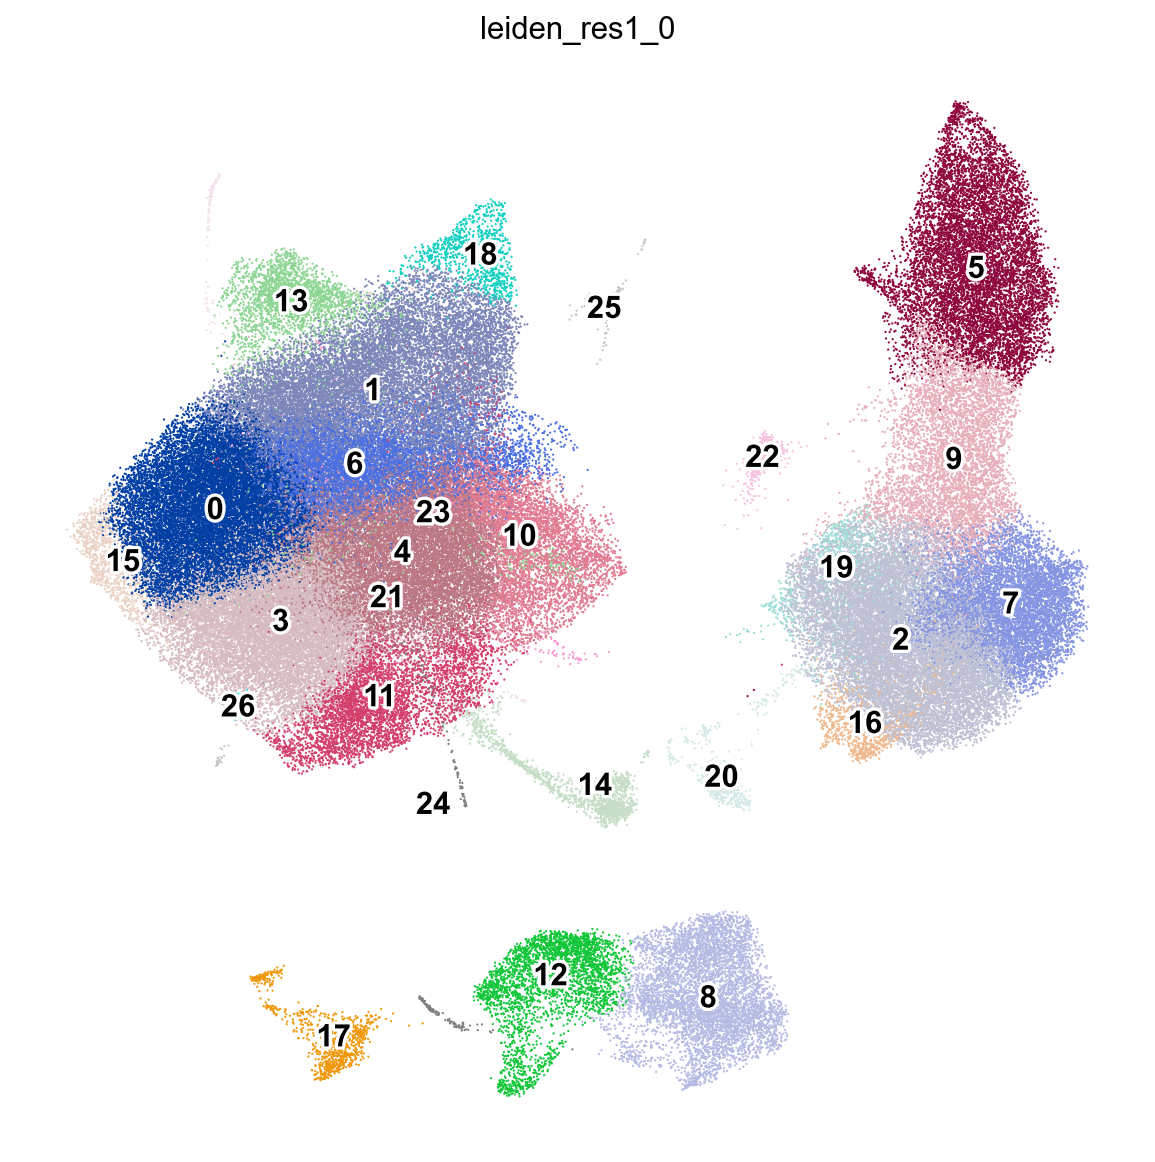

In [34]:
 with rc_context({'figure.figsize': (9,9)}):
    sc.pl.umap(adata, color=res, legend_loc="on data", size=4, legend_fontoutline=3)

In [80]:
adata.obs["cell_type_dea_previous"] = adata.obs["cell_type_dea"].copy()

In [81]:
# Rename clusters
old_to_new = {
    '0': 'capECs',
    '1': 'aECs',
    '2': 'Pericytes',
    '3': 'capECs',
    '4': 'vECs',
    '5': 'SMCs',
    '6': 'capECs',
    '7': 'Pericytes',
    '8': 'VLMCs',
    '9': 'SMCs-Pericytes',
    '10': 'vECs',
    '11': 'capECs',
    '12': 'VLMCs',
    '13': 'capECs',
    '14': 'ECs-Astro',
    '15': 'capECs',
    '16': 'Pericytes',
    '17': 'ABCs',
    '18': 'aECs',
    '19': 'Pericytes',
    '20': 'ECs-Immune',
    '21': 'capECs',
    '22': 'ECs-Pericytes',
    '23': 'capECs',
    '24': 'ECs-Other',
    '25': 'capECs',
    '26': 'capECs'
}

In [82]:
# broad cell type
adata.obs["cell_type_dea"] = adata.obs[res].map(old_to_new).astype('category')

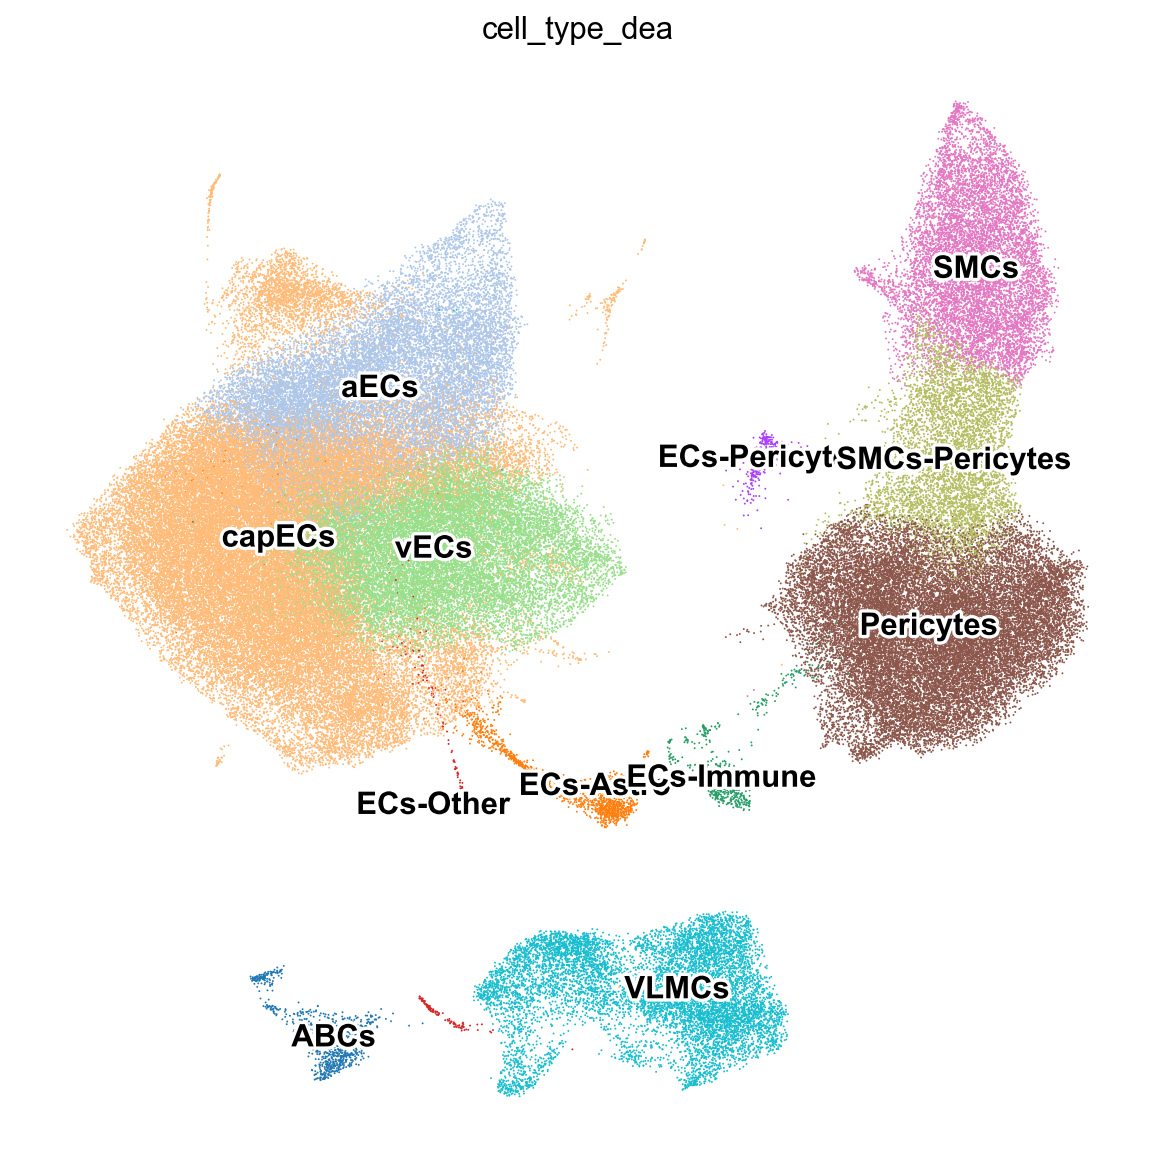

In [83]:
 with rc_context({'figure.figsize': (9,9)}):
    sc.pl.umap(adata, color="cell_type_dea", legend_loc="on data", size=3, legend_fontoutline=3)

## Pseudobulking

In [84]:
adata.X = adata.layers["counts"]

In [85]:
# check that .X contains raw counts
adata.X.max()

11045.0

In [86]:
adata.obs.head(2)

key        class     subclass  \
TGTGGTATCGGCCGAT-065_C01  WMB-10Xv2-MB-raw  33 Vascular  331 Peri NN   
GACGGCTCAAACCTAC-059_E01  WMB-10Xv2-MB-raw  33 Vascular  331 Peri NN   

                         neurotransmitter library_method cell_type_dea  \
TGTGGTATCGGCCGAT-065_C01              NaN          10Xv2     Pericytes   
GACGGCTCAAACCTAC-059_E01              NaN          10Xv2     Pericytes   

                         donor_id leiden_res0_05 leiden_res0_1 leiden_res0_2  \
TGTGGTATCGGCCGAT-065_C01   421226              1             1             1   
GACGGCTCAAACCTAC-059_E01   414907              1             1             1   

                          ... EndMT (EC) EndMT (M) Pan-Ependymal  \
TGTGGTATCGGCCGAT-065_C01  ...  -0.794971 -0.138499      0.008764   
GACGGCTCAAACCTAC-059_E01  ...  -0.747006 -0.059229      0.066743   

                         Ependymocytes cells Tanycytes  \
TGTGGTATCGGCCGAT-065_C01            0.158495 -0.021304   
GACGGCTCAAACCTAC-059_E01            0.151548 -0.021304   

                         Choroidal epithelial cells  cell_type  \
TGTGGTATCGGCCGAT-065_C01                   0.067692  Pericytes   
GACGGCTCAAACCTAC-059_E01                  -0.072378  Pericytes   

                          celltype_donorid  n_cells  cell_type_dea_previous  
TGTGGTATCGGCCGAT-065_C01  Pericytes_421226       25               Pericytes  
GACGGCTCAAACCTAC-059_E01  Pericytes_414907       23               Pericytes  

[2 rows x 110 columns]

In [87]:
# number of cells per group
adata.obs["cell_type_dea_previous"].value_counts()

ECs          88011
Pericytes    24907
SMCs         14614
VLMCs         9104
ABCs           857
Name: cell_type_dea_previous, dtype: int64

In [88]:
# number of cells per group
adata.obs["cell_type_dea"].value_counts()

capECs            49337
Pericytes         24362
vECs              19299
aECs              16702
SMCs               9253
VLMCs              8966
SMCs-Pericytes     5778
ECs-Astro          1588
ABCs                874
ECs-Immune          712
ECs-Pericytes       376
ECs-Other           246
Name: cell_type_dea, dtype: int64

In [89]:
# number of samples per group
for cell_type in adata.obs["cell_type_dea"].cat.categories:
    unique_donors = len(adata[adata.obs["cell_type_dea"] == cell_type].obs["donor_id"].cat.categories)
    print(f"{unique_donors} {cell_type}")

79 ABCs
105 ECs-Astro
100 ECs-Immune
60 ECs-Other
82 ECs-Pericytes
294 Pericytes
249 SMCs
229 SMCs-Pericytes
271 VLMCs
278 aECs
304 capECs
278 vECs


In [90]:
adata.obs["celltypedea_donorid"] = adata.obs.apply(
    lambda row: f"{row['cell_type_dea']}_{row['donor_id']}", axis=1
)

In [91]:
# add number of cells per cell_type-sample group
adata.obs['n_cells'] = adata.obs.groupby(['cell_type_dea' ,'donor_id'])['donor_id'].transform('count')

In [92]:
adata.obs[:2]

key        class     subclass  \
TGTGGTATCGGCCGAT-065_C01  WMB-10Xv2-MB-raw  33 Vascular  331 Peri NN   
GACGGCTCAAACCTAC-059_E01  WMB-10Xv2-MB-raw  33 Vascular  331 Peri NN   

                         neurotransmitter library_method cell_type_dea  \
TGTGGTATCGGCCGAT-065_C01              NaN          10Xv2     Pericytes   
GACGGCTCAAACCTAC-059_E01              NaN          10Xv2     Pericytes   

                         donor_id leiden_res0_05 leiden_res0_1 leiden_res0_2  \
TGTGGTATCGGCCGAT-065_C01   421226              1             1             1   
GACGGCTCAAACCTAC-059_E01   414907              1             1             1   

                          ... EndMT (M) Pan-Ependymal Ependymocytes cells  \
TGTGGTATCGGCCGAT-065_C01  ... -0.138499      0.008764            0.158495   
GACGGCTCAAACCTAC-059_E01  ... -0.059229      0.066743            0.151548   

                         Tanycytes Choroidal epithelial cells  cell_type  \
TGTGGTATCGGCCGAT-065_C01 -0.021304                   0.067692  Pericytes   
GACGGCTCAAACCTAC-059_E01 -0.021304                  -0.072378  Pericytes   

                          celltype_donorid  n_cells  cell_type_dea_previous  \
TGTGGTATCGGCCGAT-065_C01  Pericytes_421226       25               Pericytes   
GACGGCTCAAACCTAC-059_E01  Pericytes_414907       23               Pericytes   

                          celltypedea_donorid  
TGTGGTATCGGCCGAT-065_C01     Pericytes_421226  
GACGGCTCAAACCTAC-059_E01     Pericytes_414907  

[2 rows x 111 columns]

In [93]:
ncells = adata.obs.groupby(['cell_type_dea', 'donor_id'])['n_cells'].count()
ncells = pd.DataFrame(ncells)

In [94]:
#pd.set_option('display.max_rows', None)
#ncells
#pd.set_option('display.max_rows', 15)

In [95]:
# clean up the cell type names to avoid Python to R conversion issues
adata.obs["cell_type_dea"] = [ct.replace(" ", "_") for ct in adata.obs["cell_type_dea"]]
adata.obs["cell_type_dea"] = [ct.replace("/", "_") for ct in adata.obs["cell_type_dea"]]
adata.obs["cell_type_dea"] = [ct.replace(" ", "_") for ct in adata.obs["cell_type_dea"]]
adata.obs["cell_type_dea"] = [ct.replace("+", "") for ct in adata.obs["cell_type_dea"]]
adata.obs["cell_type_dea"] = [ct.replace("(", "") for ct in adata.obs["cell_type_dea"]]
adata.obs["cell_type_dea"] = [ct.replace(")", "") for ct in adata.obs["cell_type_dea"]]

In [96]:
# set categorical metadata to be indeed categorical to create pseudobulks
adata.obs["donor_id"] = adata.obs["donor_id"].astype("category")
adata.obs["cell_type_dea"] = adata.obs["cell_type_dea"].astype("category")
adata.obs["celltypedea_donorid"] = adata.obs["celltypedea_donorid"].astype("category")
adata.obs["n_cells"] = adata.obs["n_cells"].astype(int)

- ``aggregate_and_filter`` is a function that creates an AnnData object with one pseudo-replicate for each donor for a specified subpopulation from the original single-cell AnnData object. Here we also filter out donors that have fewer than X cells for the specified population.
- by changing the ``replicates_per_patient`` parameter, several (n) pseudo-replicates can be created for each sample; cells are then split into n subsets of roughly equal sizes.

In [97]:
obs_to_keep = ["cell_type_dea", "donor_id", "celltypedea_donorid", "n_cells", "library_method"]

In [98]:
# run pseudobluking
NUM_OF_CELL_PER_DONOR = 15 # cell_type-sample combinations must have more cells to not get excluded
cell_type_i = adata.obs["cell_type_dea"].cat.categories[0]
print(
    f'Processing {cell_type_i} (1 out of {len(adata.obs["cell_type_dea"].cat.categories)})...'
)
adata_pb = aggregate_and_filter(adata=adata, cell_identity=cell_type_i, cell_identity_key="cell_type_dea", donor_key="donor_id", obs_to_keep=obs_to_keep)
for i, cell_type_i in enumerate(adata.obs["cell_type_dea"].cat.categories[1:]):
    print(
        f'Processing {cell_type_i} ({i+2} out of {len(adata.obs["cell_type_dea"].cat.categories)})...'
    )
    adata_cell_type = aggregate_and_filter(adata=adata, cell_identity=cell_type_i, cell_identity_key="cell_type_dea", donor_key="donor_id", obs_to_keep=obs_to_keep)
    adata_pb = adata_pb.concatenate(adata_cell_type)

Processing ABCs (1 out of 12)...
Dropping the following samples:
['352353', '352357', '365619', '366676', '380340', '380345', '381293', '381295', '395345', '404123', '412866', '414905', '414906', '421226', '425676', '426003', '441865', '443005', '443636', '443644', '446701', '446714', '457911', '480180', '507771', '507773', '540566', '546762', '546763', '546799', '546811', '549928', '550468', '550850', '550851', '551017', '551018', '551639', '553672', '553679', '553680', '553682', '554811', '554920', '554922', '556108', '556112', '556113', '556231', '556943', '557213', '560333', '561533', '562458', '562809', '562810', '565823', '565824', '565913', '565914', '566251', '569504', '574608', '619870']
	Processing donor 79 out of 79...

Processing ECs-Astro (2 out of 12)...
Dropping the following samples:
['443005', '469515', '493657', '511243', '532618', '533254', '536273', '536274', '537272', '538745', '539463', '539605', '539606', '540565', '540566', '544398', '544400', '546762', '546763'

In [99]:
adata_pb.obs_names = adata_pb.obs["celltypedea_donorid"]
adata_pb.obs["n_cells"] = adata_pb.obs["n_cells"].astype(int)

In [100]:
adata_pb

AnnData object with n_obs × n_vars = 924 × 32285
    obs: 'cell_type_dea', 'donor_id', 'celltypedea_donorid', 'n_cells', 'library_method', 'batch'

In [101]:
adata_pb.X.max()

433221.0

In [102]:
pd.crosstab(adata_pb.obs["cell_type_dea"],adata_pb.obs["batch"])

batch             0    1
cell_type_dea           
ABCs             15    0
ECs-Astro        41    0
ECs-Immune        8    0
ECs-Other         3    0
ECs-Pericytes     4    0
Pericytes       142    0
SMCs            101    0
SMCs-Pericytes   97    0
VLMCs           113    0
aECs            110    0
capECs          171    0
vECs              0  119

## Explore Covariates
on PCA

In [103]:
adata_pb.layers['counts'] = adata_pb.X.copy()
adata_pb.layers['log1p_norm'] = adata_pb.X.copy()
sc.pp.normalize_total(adata_pb, target_sum=1e6, layer='log1p_norm')
sc.pp.log1p(adata_pb, layer='log1p_norm')
adata_pb.X = adata_pb.layers["log1p_norm"]

In [104]:
adata_pb.layers

Layers with keys: counts, log1p_norm

In [105]:
adata_pb.layers["log1p_norm"].max()

11.8260355

In [106]:
adata_pb.layers["counts"].max()

433221.0

In [107]:
adata_pb.obs["lib_size"] = np.sum(adata_pb.layers["counts"], axis=1)
adata_pb.obs["log_lib_size"] = np.log(adata_pb.obs["lib_size"].astype(np.float64))

In [108]:
adata_pb.obs.head(2)

cell_type_dea donor_id celltypedea_donorid  n_cells  \
celltypedea_donorid                                                       
ABCs_546759                  ABCs   546759         ABCs_546759       19   
ABCs_546810                  ABCs   546810         ABCs_546810       92   

                    library_method batch   lib_size  log_lib_size  
celltypedea_donorid                                                
ABCs_546759                  10Xv3     0   256133.0     12.453452  
ABCs_546810                  10Xv3     0  1354649.0     14.119053

In [109]:
sc.pp.pca(adata_pb)

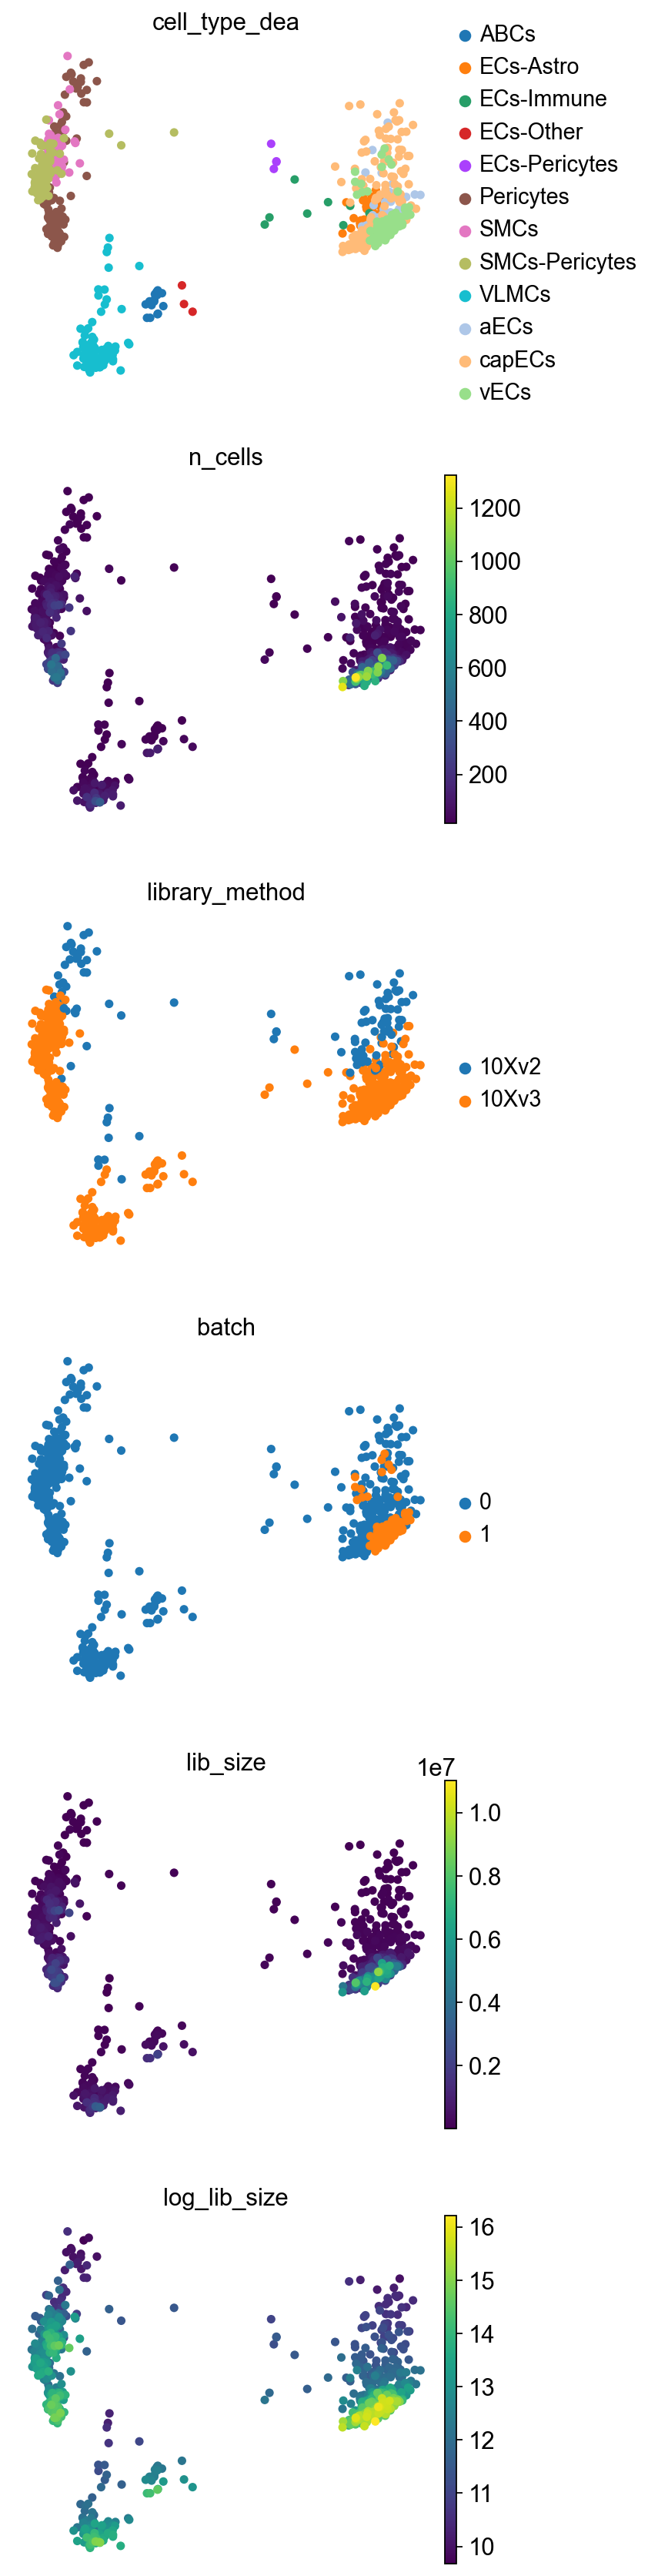

In [110]:
sc.pl.pca(adata_pb, color=adata_pb.obs.drop(columns=['celltypedea_donorid','donor_id']), ncols=1, size=100)

In [111]:
adata_pb.X = adata_pb.layers['counts'].copy()

In [112]:
del adata_pb.layers

In [113]:
del adata_pb.uns['cell_type_dea_colors']
del adata_pb.uns['batch_colors']

In [114]:
adata_pb

AnnData object with n_obs × n_vars = 924 × 32285
    obs: 'cell_type_dea', 'donor_id', 'celltypedea_donorid', 'n_cells', 'library_method', 'batch', 'lib_size', 'log_lib_size'
    uns: 'log1p', 'pca', 'library_method_colors'
    obsm: 'X_pca'
    varm: 'PCs'

In [115]:
# for compatibility
adata_pb.obs['lib_size'] = adata_pb.obs['lib_size'].astype(int)
adata_pb.obs['celltypedea_donorid'] = adata_pb.obs['celltypedea_donorid'].astype('category')
adata_pb.obs.index = adata_pb.obs['celltypedea_donorid']

In [116]:
adata_pb.obs.dtypes

cell_type_dea          category
donor_id               category
celltypedea_donorid    category
n_cells                   int64
library_method         category
batch                  category
lib_size                  int64
log_lib_size            float64
dtype: object

In [117]:
import scipy.sparse
adata_pb.X = scipy.sparse.csr_matrix(adata_pb.X, dtype='float32')

In [118]:
adata_pb.X

<924x32285 sparse matrix of type '<class 'numpy.float32'>'
	with 12664148 stored elements in Compressed Sparse Row format>

In [119]:
adata_pb.X.max()

433221.0

In [120]:
# save
adata_pb.write(os.path.join(main_dir, "ABCAtlas_Yao2023Nature", "anndata-objects", date.today().strftime("%Y%m%d") + 
                             "_vascular_subset_pseudobulks.h5ad.gz"), # 
                compression = 'gzip'
               )

In [23]:
# load
setdate = "20250206" # raw counts, pseudobulks
adata_vascular = sc.read_h5ad(os.path.join(main_dir, "ABCAtlas_Yao2023Nature", "anndata-objects", setdate + "_vascular_subset_pseudobulks.h5ad.gz"))

In [24]:
adata_vascular

AnnData object with n_obs × n_vars = 924 × 32285
    obs: 'cell_type_dea', 'donor_id', 'celltypedea_donorid', 'n_cells', 'library_method', 'batch', 'lib_size', 'log_lib_size'
    uns: 'library_method_colors', 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [25]:
adata_vascular.X.max()

433221.0

In [27]:
adata_vascular.obs["cell_type_dea"].value_counts()

capECs            171
Pericytes         142
vECs              119
VLMCs             113
aECs              110
SMCs              101
SMCs-Pericytes     97
ECs-Astro          41
ABCs               15
ECs-Immune          8
ECs-Pericytes       4
ECs-Other           3
Name: cell_type_dea, dtype: int64

# Merge pseudobulk datasets

Merge with non-vascular pseudobulk dataset 

In [16]:
# load
setdate = "20250129" # raw counts, pseudobulks, all merged
adata = sc.read_h5ad(os.path.join(main_dir, "ABCAtlas_Yao2023Nature", "anndata-objects", setdate + "_pseudobulks_all.h5ad.gz"))

In [17]:
adata

AnnData object with n_obs × n_vars = 2743 × 32285
    obs: 'cell_type_dea', 'donor_id', 'celltypedea_donorid', 'n_cells', 'library_method', 'batch', 'lib_size', 'log_lib_size'
    obsm: 'X_pca'

In [18]:
adata.X.max()

21642372.0

In [21]:
# subset vascular cells
adata = adata[~adata.obs["cell_type_dea"].isin(["Pericytes", "ECs", "VLMCs", "ABCs", "SMCs"])].copy()

In [22]:
adata

AnnData object with n_obs × n_vars = 2146 × 32285
    obs: 'cell_type_dea', 'donor_id', 'celltypedea_donorid', 'n_cells', 'library_method', 'batch', 'lib_size', 'log_lib_size'
    obsm: 'X_pca'

In [29]:
# merge
adata

AnnData object with n_obs × n_vars = 2146 × 32285
    obs: 'cell_type_dea', 'donor_id', 'celltypedea_donorid', 'n_cells', 'library_method', 'batch', 'lib_size', 'log_lib_size'
    obsm: 'X_pca'

In [28]:
adata_vascular

AnnData object with n_obs × n_vars = 924 × 32285
    obs: 'cell_type_dea', 'donor_id', 'celltypedea_donorid', 'n_cells', 'library_method', 'batch', 'lib_size', 'log_lib_size'
    uns: 'library_method_colors', 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [31]:
adata_merged = adata.concatenate(adata_vascular)
adata_merged

AnnData object with n_obs × n_vars = 3070 × 32285
    obs: 'cell_type_dea', 'donor_id', 'celltypedea_donorid', 'n_cells', 'library_method', 'batch', 'lib_size', 'log_lib_size'
    obsm: 'X_pca'

In [37]:
adata_merged.obs.head(2)

cell_type_dea donor_id celltypedea_donorid  n_cells  \
celltypedea_donorid                                                       
Astrocytes_352353-0    Astrocytes   352353   Astrocytes_352353      142   
Astrocytes_352356-0    Astrocytes   352356   Astrocytes_352356      174   

                    library_method batch  lib_size  log_lib_size  
celltypedea_donorid                                               
Astrocytes_352353-0          10Xv2     0    434153     12.981152  
Astrocytes_352356-0          10Xv2     0    608173     13.318215

In [40]:
# save
adata_merged.write(os.path.join(main_dir, "ABCAtlas_Yao2023Nature", "anndata-objects", date.today().strftime("%Y%m%d") + 
                             "_pseudobulks_all_inclzonation.h5ad.gz"),
                compression = 'gzip'
               )